In [1]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

2024-06-23 14:47:22.852982: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 14:47:22.906372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 14:47:23.725128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False


2024-06-23 14:47:25.219353: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
import os
import pandas
import numpy as np
import cv2
from random import randint
import matplotlib.pyplot as plt
import time
import seaborn as sns

# TL preps

In [3]:
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-10)  # Dodaję niewielką wartość by uniknąć dzielenia przez 0

def plot_metrics(history):
    epochs = range(1, len(history.history['categorical_accuracy']) + 1)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Categorical Accuracy
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history.history['categorical_accuracy'], label='Train')
    plt.plot(epochs, history.history['val_categorical_accuracy'], label='Test')
    plt.title('Categorical Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical Accuracy')
    plt.legend()
    plt.xticks(epochs)

    # Loss
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history.history['loss'], label='Train')
    plt.plot(epochs, history.history['val_loss'], label='Test')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

In [4]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=90,
                            horizontal_flip=False,
                            vertical_flip=False,
                            channel_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            rescale=1./255,
                            brightness_range=(0.5,1),
                            validation_split=0.3)


In [5]:
root_dir = 'common/Dog Emotion'

img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 2800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


# ResNet50V2

In [60]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")#4 classes
])

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [62]:
model.fit(img_generator_flow_train,
          validation_data=img_generator_flow_valid,
          epochs=10)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - categorical_accuracy: 0.3054 - loss: 4.1813 - val_categorical_accuracy: 0.4225 - val_loss: 2.9925
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 981ms/step - categorical_accuracy: 0.4599 - loss: 2.5287 - val_categorical_accuracy: 0.4850 - val_loss: 2.3890
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 998ms/step - categorical_accuracy: 0.5016 - loss: 2.1765 - val_categorical_accuracy: 0.5225 - val_loss: 2.1277
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.5419 - loss: 1.9089 - val_categorical_accuracy: 0.5258 - val_loss: 2.1428
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 980ms/step - categorical_accuracy: 0.5458 - loss: 1.9350 - val_categorical_accuracy: 0.5317 - val_loss: 2.0447
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 973ms/step - categorical_accuracy: 0.5823 - loss: 1.6697 - val_categorical_accuracy: 0.5650 - val_loss: 1.8491
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 985ms/step - categorical_accuracy: 0.5848 - lo

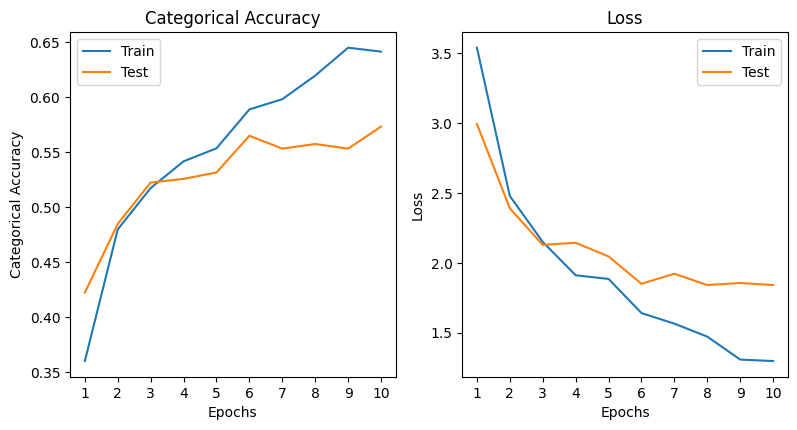

In [63]:
plot_metrics(model.history)

In [64]:
model.save("ResNet50V2.keras")

# InceptionV3

In [53]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")#4 classes
])

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [55]:
model.fit(img_generator_flow_train,
          validation_data=img_generator_flow_valid,
          epochs=10)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 903ms/step - categorical_accuracy: 0.2886 - loss: 2.2403 - val_categorical_accuracy: 0.3858 - val_loss: 1.5984
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 835ms/step - categorical_accuracy: 0.4550 - loss: 1.4950 - val_categorical_accuracy: 0.4625 - val_loss: 1.4636
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 829ms/step - categorical_accuracy: 0.4823 - loss: 1.3551 - val_categorical_accuracy: 0.4925 - val_loss: 1.3496
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 811ms/step - categorical_accuracy: 0.5239 - loss: 1.2608 - val_categorical_accuracy: 0.4892 - val_loss: 1.3277
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 808ms/step - categorical_accuracy: 0.5623 - loss: 1.1744 - val_categorical_accuracy: 0.5275 - val_loss: 1.3007
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 822ms/step - categorical_accuracy: 0.5855 - loss: 1.0970 - val_categorical_accuracy: 0.5317 - val_loss: 1.2085
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 801ms/step - categorical_accuracy: 0.574

In [59]:
model.save("InceptionV3.keras")

# ResNet50V2 - więcej epoch (Wybrany do aplikacji)

In [9]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")#4 classes
])

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [12]:
model.fit(img_generator_flow_train,
          validation_data=img_generator_flow_valid,
          epochs=20)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - categorical_accuracy: 0.3141 - loss: 4.1537 - val_categorical_accuracy: 0.4333 - val_loss: 2.9335
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 971ms/step - categorical_accuracy: 0.4758 - loss: 2.4666 - val_categorical_accuracy: 0.4658 - val_loss: 2.5178
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 980ms/step - categorical_accuracy: 0.5272 - loss: 2.1654 - val_categorical_accuracy: 0.4958 - val_loss: 2.3721
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 969ms/step - categorical_accuracy: 0.5517 - loss: 1.9870 - val_categorical_accuracy: 0.5050 - val_loss: 2.1687
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 975ms/step - categorical_accuracy: 0.5936 - loss: 1.6227 - val_categorical_accuracy: 0.5233 - val_loss: 2.1233
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 974ms/step - categorical_accuracy: 0.5745 - loss: 1.6763 - val_categorical_accuracy: 0.5400 - val_loss: 2.0274
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 960ms/step - categorical_accuracy: 0.6067 -

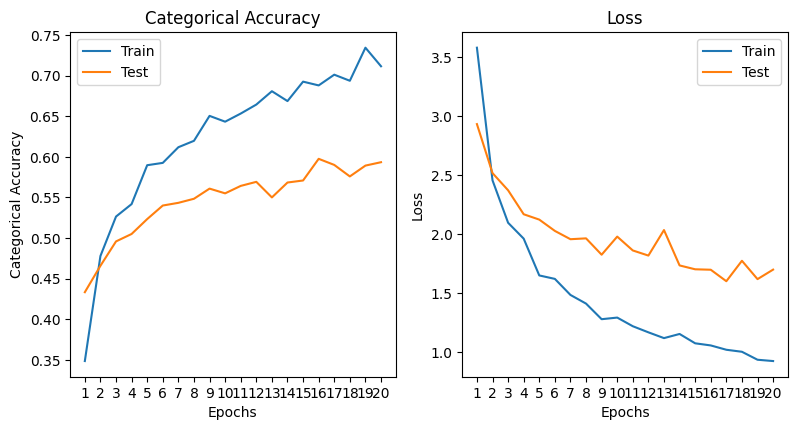

In [13]:
plot_metrics(model.history)

In [14]:
model.save("ResNet50V2.keras")

# ResNet50V2 - bez MaxPooling

In [18]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")#4 classes
])

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [20]:
model.fit(img_generator_flow_train,
          validation_data=img_generator_flow_valid,
          epochs=10)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - categorical_accuracy: 0.3953 - loss: 2.5669 - val_categorical_accuracy: 0.5183 - val_loss: 1.9538
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 985ms/step - categorical_accuracy: 0.5898 - loss: 1.5425 - val_categorical_accuracy: 0.5233 - val_loss: 1.8580
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 90s 989ms/step - categorical_accuracy: 0.6203 - loss: 1.3596 - val_categorical_accuracy: 0.5525 - val_loss: 1.8366
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 965ms/step - categorical_accuracy: 0.6897 - loss: 1.1330 - val_categorical_accuracy: 0.5625 - val_loss: 1.7025
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 980ms/step - categorical_accuracy: 0.7076 - loss: 1.0696 - val_categorical_accuracy: 0.5750 - val_loss: 1.8865
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 980ms/step - categorical_accuracy: 0.7155 - loss: 0.9755 - val_categorical_accuracy: 0.5733 - val_loss: 1.6608
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 90s 991ms/step - categorical_accuracy: 0.7332 -

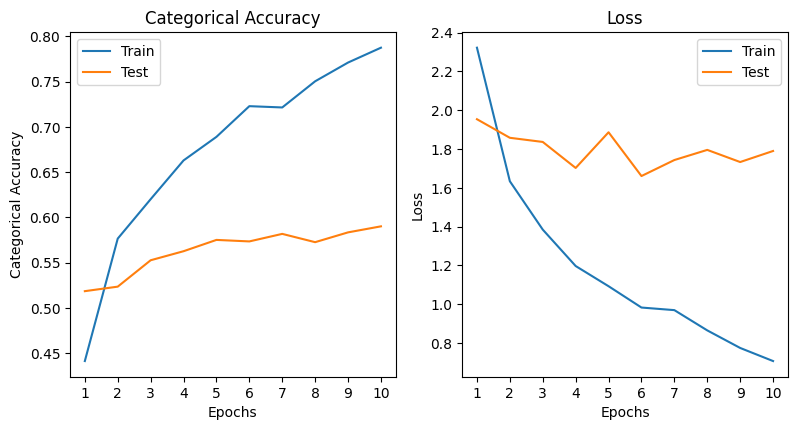

In [21]:
plot_metrics(model.history)

# InceptionV3 - więcej epoch (Wybrany do aplikacji)

In [23]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")#4 classes
])

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [25]:
model.fit(img_generator_flow_train,
          validation_data=img_generator_flow_valid,
          epochs=20)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 851ms/step - categorical_accuracy: 0.3038 - loss: 2.2541 - val_categorical_accuracy: 0.4267 - val_loss: 1.6496
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 828ms/step - categorical_accuracy: 0.4265 - loss: 1.5059 - val_categorical_accuracy: 0.4358 - val_loss: 1.5158
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 816ms/step - categorical_accuracy: 0.4967 - loss: 1.3606 - val_categorical_accuracy: 0.4742 - val_loss: 1.4697
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 819ms/step - categorical_accuracy: 0.5371 - loss: 1.2890 - val_categorical_accuracy: 0.4792 - val_loss: 1.4110
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 810ms/step - categorical_accuracy: 0.5541 - loss: 1.1560 - val_categorical_accuracy: 0.4933 - val_loss: 1.3922
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 821ms/step - categorical_accuracy: 0.5743 - loss: 1.1073 - val_categorical_accuracy: 0.5192 - val_loss: 1.3409
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 821ms/step - categorical_accuracy: 0.578

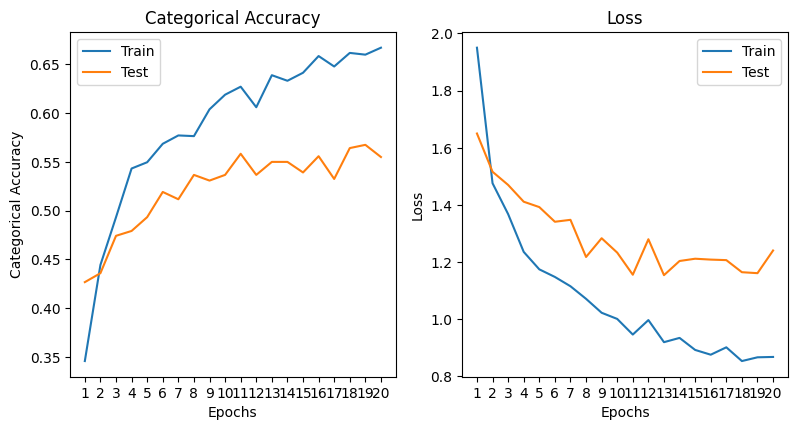

In [26]:
plot_metrics(model.history)

In [27]:
model.save("InceptionV3.keras")

# InceptionV3 - bez MaxPooling

In [28]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")#4 classes
])

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [30]:
model.fit(img_generator_flow_train,
          validation_data=img_generator_flow_valid,
          epochs=10)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 836ms/step - categorical_accuracy: 0.3525 - loss: 2.3201 - val_categorical_accuracy: 0.4158 - val_loss: 1.7868
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 784ms/step - categorical_accuracy: 0.5356 - loss: 1.3284 - val_categorical_accuracy: 0.5033 - val_loss: 1.3850
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 804ms/step - categorical_accuracy: 0.5889 - loss: 1.2078 - val_categorical_accuracy: 0.4917 - val_loss: 1.8782
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 796ms/step - categorical_accuracy: 0.5902 - loss: 1.2656 - val_categorical_accuracy: 0.5492 - val_loss: 1.3997
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 811ms/step - categorical_accuracy: 0.6301 - loss: 1.0358 - val_categorical_accuracy: 0.5400 - val_loss: 1.3908
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 803ms/step - categorical_accuracy: 0.6787 - loss: 0.9385 - val_categorical_accuracy: 0.5600 - val_loss: 1.3908
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 816ms/step - categorical_accuracy: 0.680

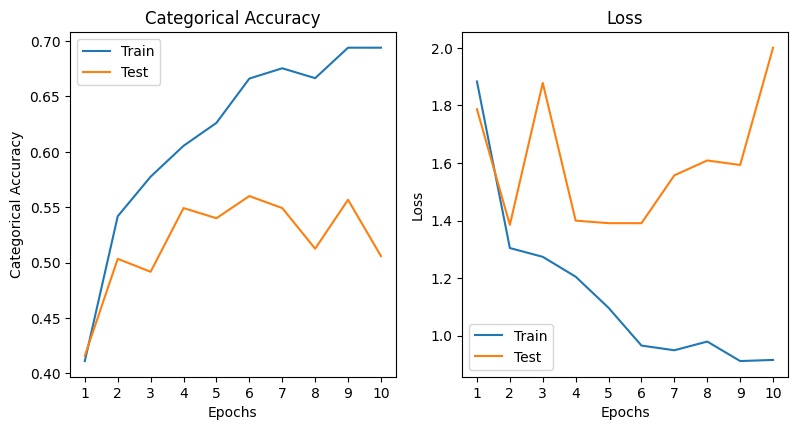

In [31]:
plot_metrics(model.history)

In [32]:
model.save("InceptionV3.keras")